# Running GNN on real-world tracked data

In [182]:
%load_ext autoreload
%autoreload 2

from collab_env.data.file_utils import expand_path, get_project_root
import matplotlib.pyplot as plt
from rich import print
import seaborn as sns
import pandas as pd
import pickle
import torch

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Current format consumed by the GNN

In [61]:
boid_dummy_data_fn = expand_path(
    "simulated_data/boid_single_species_basic.pt",
    get_project_root(),
)

boid_dummy_ds = torch.load(boid_dummy_data_fn, weights_only = False)
print(type(boid_dummy_ds))
print(f"Length of boid_dummy_ds: {len(boid_dummy_ds)}")
p, sp = next(iter(boid_dummy_ds))
print(f"p.shape: {p.shape}, sp.shape: {sp.shape}")

<class 'collab_env.sim.boids_gnn_temp.animal_simulation.AnimalTrajectoryDataset'>

Length of boid_dummy_ds: 1000

p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

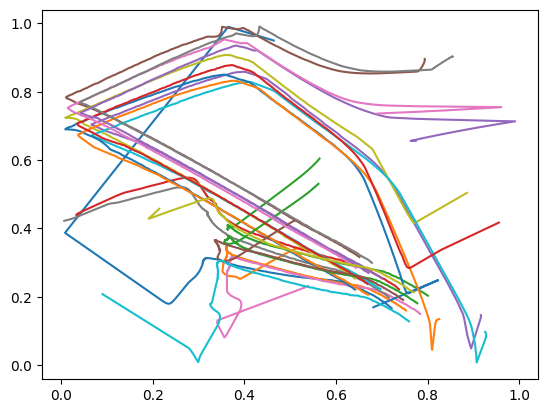

In [17]:
plt.figure()
plt.plot(p[..., 0], p[..., 1])
plt.show()

## The Data

In [18]:
real_data_fn = expand_path(
    "data/fieldwork_processed/2023_11_26-session_0001/aligned_frames/rgb_1/rgb_1_tracks.csv",
    get_project_root(),
)

real_data = pd.read_csv(real_data_fn)

print(real_data.head())

track_id  frame    x    y
0       1.0      0  448  232
1       1.0      1  437  236
2       1.0      2  434  242
3       1.0      3  430  250
4       1.0      4  430  260

In [29]:
# normalize x,y to [0,1] x [0,1]
real_data = real_data.assign(
    x_norm = lambda x: (x.x - x.x.min()) / (x.x.max() - x.x.min()),
    y_norm = lambda x: (x.y - x.y.min()) / (x.y.max() - x.y.min()),
)

In [66]:
max_seq_len = real_data.track_id.value_counts().max()
max_frame_id = real_data.frame.max() + 1
track_ids = real_data.track_id.unique()

print(f"max_seq_len: {max_seq_len}, max_frame_id: {max_frame_id}, track_ids: {len(track_ids)}")

all_tracks = torch.nan * torch.zeros(len(track_ids), max_frame_id, 2, dtype=torch.float64)
all_tracks_mask = torch.zeros(len(track_ids), max_frame_id, dtype=torch.bool)

for i, track_id in enumerate(track_ids):
    track = real_data[real_data.track_id == track_id]
    all_tracks[i, track.frame.astype(int).values, :] = torch.tensor(track[['x_norm', 'y_norm']].values)
    all_tracks_mask[i, track.frame.values] = True
    
print(f"all_tracks.shape: {all_tracks.shape}")
print(f"all_tracks_mask.shape: {all_tracks_mask.shape}")

max_seq_len: 2233, max_frame_id: 9762, track_ids: 210

all_tracks.shape: torch.Size([210, 9762, 2])

all_tracks_mask.shape: torch.Size([210, 9762])

In [179]:
def plot_tracks(tracks, mask, title="Tracks"):
    fix, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].spy(mask, aspect='auto')
    ax[0].set_xlabel("Frame")
    ax[0].set_ylabel("Track ID")
    ax[0].set_title("Tracks mask")
    ax[1].plot(tracks[...,0], tracks[...,1])
    ax[1].set_title("Real Tracks")
    plt.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()

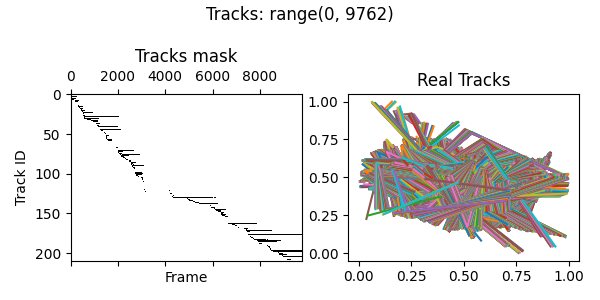

In [180]:
frame_rng = range(max_frame_id)
plot_tracks(all_tracks[...,frame_rng, :], all_tracks_mask[...,frame_rng], title=f"Tracks: {frame_rng}")

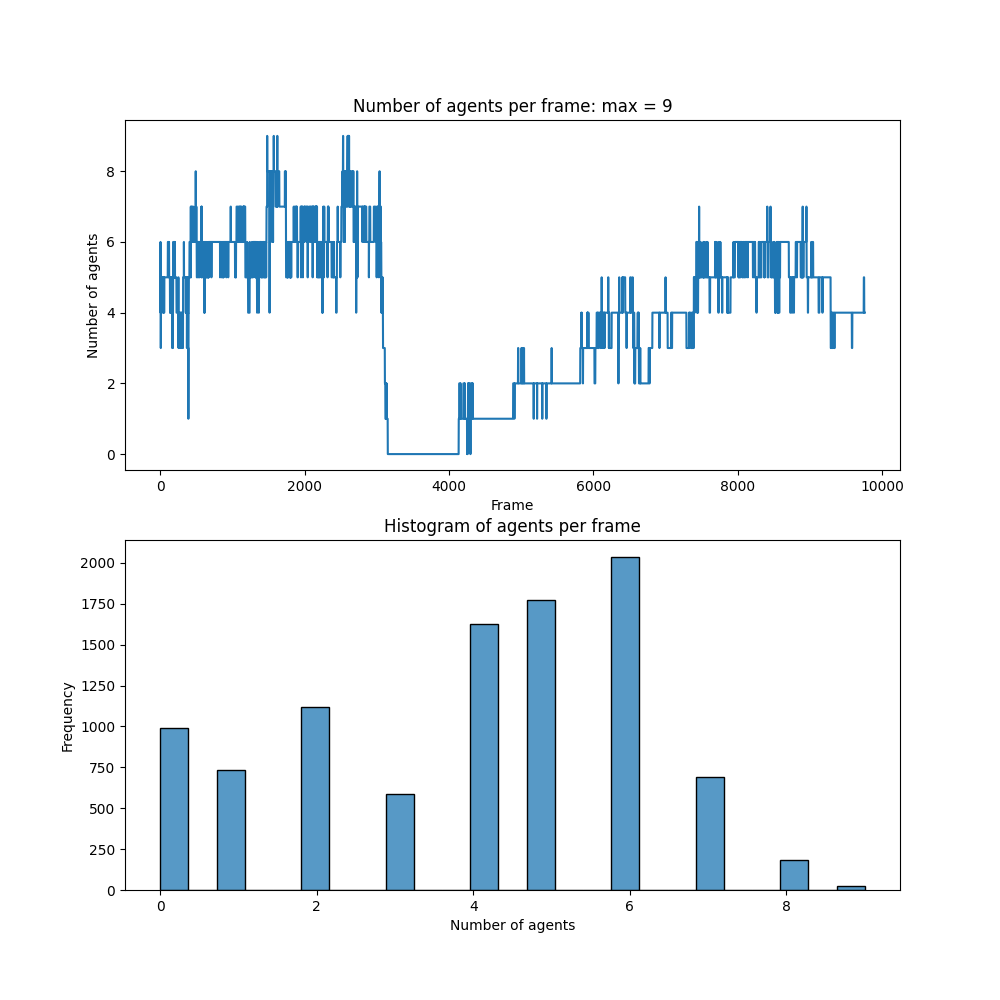

In [184]:
# max. number of agents in a frame
max_agents_per_frame = all_tracks_mask.sum(dim=0).max()
agents_per_frame = all_tracks_mask.sum(dim=0)
fig, ax = plt.subplots(2,1, figsize=(10, 10))
ax[0].plot(agents_per_frame)
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("Number of agents")
ax[0].set_title(f"Number of agents per frame: max = {max_agents_per_frame}")

sns.histplot(agents_per_frame, ax=ax[1])
ax[1].set_xlabel("Number of agents")
ax[1].set_ylabel("Frequency")
ax[1].set_title(f"Histogram of agents per frame")
plt.show()
# split into shorter tracks and stack into a dataset

### Attempt 1 - sliding windows of large size (similar to "files")

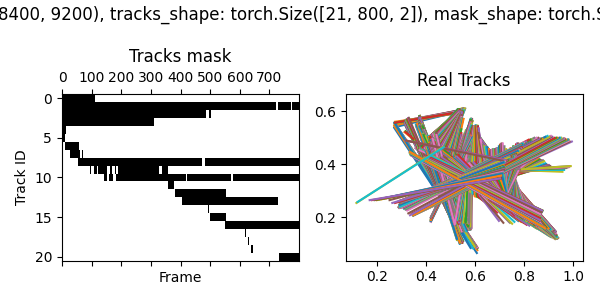

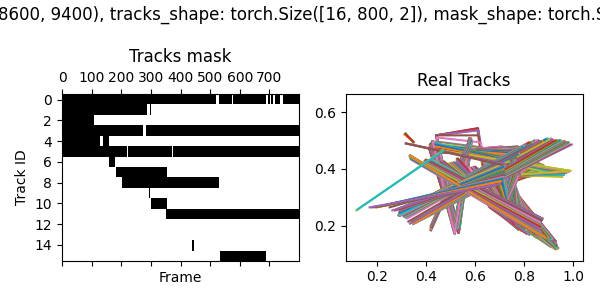

In [181]:
frame_window = 800
window_step = 200

for i in range(0, max_frame_id-frame_window, window_step)[-3:-1]:
    frame_rng = range(i, i + frame_window)
    mask = torch.zeros_like(all_tracks_mask)
    mask[:,frame_rng]  = 1
    mask_window = mask & all_tracks_mask
    row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
    col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
    tracks_window = all_tracks[row_indices,col_indices,:]
    mask_window_final = mask_window[row_indices,col_indices]
    
    plot_tracks(tracks_window, mask_window_final, title=f"Tracks: {frame_rng}, tracks_shape: {tracks_window.shape}, mask_shape: {mask_window_final.shape}")


### Attempt 2 - constant #agents chunks

In [186]:
agents_per_frame.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [217]:
agents_per_frame[:5]

tensor([5, 5, 5, 6, 6])

In [ ]:
for n_agents in agents_per_frame.unique():
    frame_indices = torch.where(agents_per_frame == n_agents)[0]
    chunks = []
    chunk_start = frame_indices[0]
    prev_chunk_frame = frame_indices[0]
    for frame in frame_indices[1:]:
        if frame == prev_chunk_frame + 1:
            prev_chunk_frame = frame
        else:
            chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))
            chunk_start = frame
            prev_chunk_frame = frame
    chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))
    ## sanity check
    for chunk in chunks:
        assert agents_per_frame[chunk[0]:chunk[1]+1].unique() == torch.tensor([n_agents]), f"{n_agents}: {chunk} "
    
    print(f"n_agents: {n_agents}, #chunks: {len(chunks)}")



n_agents: 0, #chunks: 4

n_agents: 1, #chunks: 24

n_agents: 2, #chunks: 33

n_agents: 3, #chunks: 59

n_agents: 4, #chunks: 104

n_agents: 5, #chunks: 192

n_agents: 6, #chunks: 200

n_agents: 7, #chunks: 89

n_agents: 8, #chunks: 30

n_agents: 9, #chunks: 8

In [266]:
agents_per_frame[chunk[0]:chunk[1]]

tensor([], dtype=torch.int64)

In [262]:
breakpoints2

tensor([5351, 3129, 3134, 3151, 4141, 4159, 4198, 4218, 4250, 4255, 4263, 4269,
        4271, 4283, 4295, 4301, 4317, 4325, 4888, 4907, 5175, 5221, 5293])